In [1]:
import numpy as np     
import pandas as pd
import matplotlib                          
import matplotlib.pyplot as plt
from pykat import finesse                 
from pykat.commands import *               
from pykat.optics.maps import * 
import pandas as pd
from pykat.parallel import parakat

%config InlineBackend.figure_format='svg'
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
#clipping loss of 1ppm
katHG33 = pykat.finesse.kat()
katHG33.verbose=False
katHG33.parse("""
l laser 1 0 0 n0
s s0 1 n0 nmod1

mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1

m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 3.8 n3 n4

#higher order mode TEM33
tem laser 0 0 0.0 0.0
tem laser 3 3 1.0 0.0

#Gaussian model
#Rc=2013.35 so that the loss is 1ppm
cav cavity ITM n2 ETM n3
attr ITM Rc -2679.93
attr ETM Rc 2679.93
#Rc=2679.93 when clipping loss is 1ppm for HG33

pd1 pdh 60M 0 n1

set err pdh re
lock clock $err 1 1n
put* ETM phi $clock


maxtem 8

""")

In [3]:
#clipping loss of 1ppm
katLG22 = pykat.finesse.kat()
katLG22.verbose=False
katLG22.parse("""

l laser 1 0 0 n0
#gauss g1 laser n0 1m 0
maxtem 8

s s0 1 n0 nmod1
mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1
m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 26.5 n3 n4

#higher order mode LG22
tem laser 0 0 0 0
tem laser 6 0 0.234375 0
tem laser 5 1 0.15625 -90
tem laser 4 2 0.015625 0
tem laser 3 3 0.1875 -90
tem laser 2 4 0.015625 180
tem laser 1 5 0.15625 -90
tem laser 0 6 0.234375 180

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -2789.58
attr ETM Rc 2789.58
#Rc=2789.58 when clipping loss is 1ppm for LG22

pd1 pdh 60M 0 n1
set err pdh re
lock clock $err 1 1n
put* ETM phi $clock

""")

In [4]:
# using ad to calculate the mode loss for HG33 instead of using purity

kat1 = katHG33.deepcopy()
kat1.parse("""
        pd Pcirc n3
        map ETM Z2-2order0phasemap.txt
        """)
kat1.noxaxis = True
out1=kat1.run()
Power=out1["Pcirc"]


pk2=parakat()
for n in range(7):
    for m in range(-n,n+1,2):
        kat2 = katHG33.deepcopy()
        kat2.parse(f"""
                map ETM Z{n}{m}order1phasemap.txt
                ad AD33 3 3 0 n3
                """)
        kat2.noxaxis = True
        pk2.run(kat2)
out2 = pk2.getResults()

HGloss1=[]
for i in range(28):
    loss=1-np.abs(out2[i]['AD33'])**2/Power
    HGloss1.append(loss)
    
pd.Series(HGloss1).to_pickle('pkl/HG33lossad.pkl')

/opt/anaconda3/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for [Liu]: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
Parallel jobs: 100%|##########################################################|

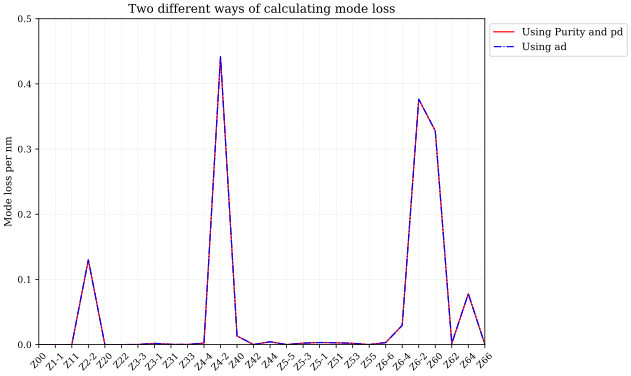

In [5]:
HG33lossZnm_array=pd.read_pickle('pkl/HG33loss.pkl').values #using purity and pd
HG33lossZnm_arrayad=pd.read_pickle('pkl/HG33lossad.pkl').values #using ad

xticks=['Z00','Z1-1','Z11','Z2-2','Z20','Z22','Z3-3','Z3-1','Z31','Z33','Z4-4','Z4-2','Z40','Z42','Z44','Z5-5','Z5-3','Z5-1','Z51','Z53','Z55','Z6-6','Z6-4','Z6-2','Z60','Z62','Z64','Z66']
fig,ax =plt.subplots(figsize=(8,6))
ax.plot(HG33lossZnm_array,'r-',label='Using Purity and pd')
ax.plot(HG33lossZnm_arrayad,'b-.',label='Using ad')
ax.set_ylabel("Mode loss per nm")
ax.set_title("Two different ways of calculating mode loss")
ax.set_ylim(0,0.5)
ax.set_xticks(range(28))
ax.set_xticklabels(xticks,rotation=45, fontsize=9)
ax.legend(loc=2,bbox_to_anchor=(1,1))
plt.show()

In [6]:
#the mean absolute difference
np.mean((HG33lossZnm_arrayad-HG33lossZnm_array)/(HG33lossZnm_arrayad+HG33lossZnm_array))

0.07330470362204844

In [7]:
# using HG2LG function to calculate the purity for LG22
pk=parakat()
for n in range(7):
    for m in range(-n,n+1,2):
        LG22purity = katLG22.deepcopy()
        LG22purity.parse(f"""
                map ETM Z{n}{m}order1phasemap.txt
                pd Pcirc n3
                ad AD60 6 0 0 n3
                ad AD51 5 1 0 n3
                ad AD42 4 2 0 n3
                ad AD33 3 3 0 n3
                ad AD24 2 4 0 n3
                ad AD15 1 5 0 n3
                ad AD06 0 6 0 n3
                yaxis abs:deg
                """)
        LG22purity.noxaxis = True
        pk.run(LG22purity)
out = pk.getResults()

LGpurity1=[]
for i in range(28):
    power=out[i]["Pcirc"]
    LGmode=0
    for n in range(7):
        for m in range(6,-1,-1):
            if n+m==6:
                coeff,p,l = pykat.optics.gaussian_beams.HG2LG(n,m)
                LGmode += coeff[np.where(l == 2)]*out[i][f"AD{n}{m}"]
    purity=np.sqrt(np.abs(LGmode)**2/np.abs(power))
    LGpurity1.append(purity)
    
pd.Series(LGpurity1).to_pickle('pkl/LG22purityfunc.pkl')

Parallel jobs: 100%|##########################################################|

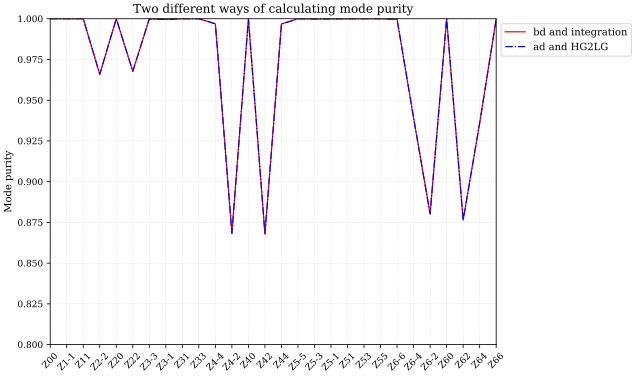

In [8]:
LG22purityZnm_array=pd.read_pickle('pkl/LG22purity.pkl').values
LG22purityZnm_arrayfunc=pd.read_pickle('pkl/LG22purityfunc.pkl').values

xticks=['Z00','Z1-1','Z11','Z2-2','Z20','Z22','Z3-3','Z3-1','Z31','Z33','Z4-4','Z4-2','Z40','Z42','Z44','Z5-5','Z5-3','Z5-1','Z51','Z53','Z55','Z6-6','Z6-4','Z6-2','Z60','Z62','Z64','Z66']
fig,ax =plt.subplots(figsize=(8,6))
ax.plot(LG22purityZnm_array,'r-',label='bd and integration')
ax.plot(LG22purityZnm_arrayfunc,'b-.',label='ad and HG2LG')
ax.set_ylabel("Mode purity")
ax.set_title("Two different ways of calculating mode purity")
ax.set_ylim(0.8,1)
ax.set_xticks(range(28))
ax.set_xticklabels(xticks,rotation=45, fontsize=9)
ax.legend(loc=2,bbox_to_anchor=(1,1))
plt.show()

In [9]:
np.mean(np.abs((LG22purityZnm_arrayfunc-LG22purityZnm_array))/(LG22purityZnm_arrayfunc+LG22purityZnm_array))

array([1.41921936e-06])